## One Shot Experiment With the Convert Interacting ... task

In [1]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.7 MB/s eta 0:00:00


In [2]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.0 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/nmudur/HartreeFock_GPT.git

Cloning into 'HartreeFock_GPT'...
remote: Enumerating objects: 1107, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 1107 (delta 120), reused 126 (delta 116), pack-reused 966
Receiving objects: 100% (1107/1107), 45.89 MiB | 31.18 MiB/s, done.
Resolving deltas: 100% (681/681), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import os
import json
import pprint
import pandas as pd
import yaml

In [ ]:
DF_DIR = '/content/drive/MyDrive/HF annotation/datasets/'
annotated_df = pd.read_csv(DF_DIR+'df_combined.csv', dtype={'arxiv_id': str})

In [ ]:
annotated_df.columns

Index(['arxiv_id', 'task', 'excerpt', 'blank_templates', 'gt_mapping',
       'annotated_prompts', 'annotated'],
      dtype='object')

In [ ]:
annotated_df.head(5)

,arxiv_id,task,excerpt,blank_templates,gt_mapping,annotated_prompts,annotated
0,0812.2894,Construct Kinetic Hamiltonian (lattice version),interaction term $H_{\rm int}$. The hopping te...,You will be instructed to describe the kinetic...,"{""system"": ""an electron""}",You will be instructed to describe the kinetic...,True
1,0812.2894,"Construct interaction Hamiltonian (real space,...",%\n\begin{eqnarray}\label{E.Hint}\nH_{\rm int}...,You will be instructed to construct the intera...,{},You will be instructed to construct the intera...,False
2,0812.2894,Convert noninteracting Hamiltonian in real spa...,simpler form when transformed to momentum spac...,You will be instructed to convert the noninter...,{},You will be instructed to convert the noninter...,False
3,0812.2894,Convert interacting Hamiltonian in real space ...,%\n\begin{eqnarray}\label{E.Hint}\nH_{\rm int}...,You will be instructed to convert the interact...,{},You will be instructed to convert the interact...,False
4,0812.2894,Wick's theorem,the projected weight of each orbital at both t...,You will be instructed to perform a Hartree-Fo...,{},You will be instructed to perform a Hartree-Fo...,False


In [ ]:
task_df = annotated_df[annotated_df['task']=='Convert interacting Hamiltonian in real space to momentum space (lattice version)']

In [ ]:
len(task_df)

9

In [ ]:
task_df['arxiv_id']

3       0812.2894
15      0902.1336
27      1106.6060
36      1310.2674
59     2004.04168
66     2008.08998
74     2012.04554
97     2110.11330
128    2308.03843
Name: arxiv_id, dtype: object

### Craft One-Shot Prompt

In [ ]:
task_specific_prompt = task_df['blank_templates'].iloc[0].split('\n===')[0]

In [ ]:
pprint.pprint(task_specific_prompt)

('You will be instructed to convert the interacting Hamiltonian, '
 '{second_int_symbol}, in the {single-particle|second-quantized} form the '
 'basis in real space to the basis in momentum space.\n'
 'To do that, you should apply the Fourier transformation to '
 '{real_creation_op} in the real space to the {momentum_creation_op} in the '
 'momentum space, which is defined as {definition_of_Fourier_Transformation}, '
 'where {real_variable} is integrated over all sites in the entire real space, '
 'and {momentum_var} is defined within the first Brillouin zone. You should '
 'follow the EXAMPLE below to apply the Fourier transformation. [Note that '
 'interaction have no position dependence now]\n'
 'You should recall that {second_int_symbol} is {expression_int}.\n'
 'Express {second_int_symbol} in terms of {momentum_creation_op}. Simplify any '
 'summation index if possible.  \n')


In [ ]:
baseline_prompt = """I will provide you a Excerpt of physics paper, and a Template. You will need to fill the placeholders in the template using the correct information from the excerpt.
Here are conventions:
{..} means a placeholder which you need to fill by extracting information from the excerpt.
{A|B} means you need to make a choice between A and B
[..] means optional sentence. You should decide whether to use it depending on the excerpt. If it applies to the excerpt, append TRUE within the [], otherwise append FALSE.
{{..}} DOES NOT mean a placeholder. You should not change the content inside double curly braces {{..}}.
`You should recall that {expression_second_nonint}.` : this sentence should be kept as is.

Finally, if you cannot figure out the placeholder, you should leave it as is.

TEMPLATE: [[template]]
"""
baseline_prompt = baseline_prompt.replace('[[template]]', task_specific_prompt.strip('\n'))

In [ ]:
example_prompt = """===
Here is an example of an excerpt and its completed template.
EXCERPT: [[example_excerpt0]]
COMPLETED TEMPLATE: [[example_answer0]]
===
Now generate the completed template for the following excerpt.
EXCERPT: [[problem_excerpt]]
"""

In [ ]:
final_prompt = baseline_prompt+'\n'+example_prompt

In [ ]:
final_prompt = final_prompt.replace('[Note that '
 'interaction have no position dependence now]', '[Note that '
 'interaction have no position dependence now: {TRUE|FALSE}]')

In [ ]:
pprint.pprint(final_prompt)

('I will provide you a Excerpt of physics paper, and a Template. You will need '
 'to fill the placeholders in the template using the correct information from '
 'the excerpt.\n'
 'Here are conventions:\n'
 '{..} means a placeholder which you need to fill by extracting information '
 'from the excerpt.\n'
 '{A|B} means you need to make a choice between A and B\n'
 '[..] means optional sentence. You should decide whether to use it depending '
 'on the excerpt. If it applies to the excerpt, append TRUE within the [], '
 'otherwise append FALSE.\n'
 '{{..}} DOES NOT mean a placeholder. You should not change the content inside '
 'double curly braces {{..}}.\n'
 '`You should recall that {expression_second_nonint}.` : this sentence should '
 'be kept as is.\n'
 '\n'
 'Finally, if you cannot figure out the placeholder, you should leave it as '
 'is.\n'
 '\n'
 'TEMPLATE: You will be instructed to convert the interacting Hamiltonian, '
 '{second_int_symbol}, in the {single-particle|second-quan

In [ ]:
# @title Example
eg_paper = "2110.11330" # @param {type:"string"}

In [ ]:
eg_info = task_df[task_df['arxiv_id']==eg_paper]

In [ ]:
eg_info

,arxiv_id,task,excerpt,blank_templates,gt_mapping,annotated_prompts,annotated
97,2110.11330,Convert interacting Hamiltonian in real space ...,\begin{equation}\label{eq:H}\n \begin{split...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""$H_{int}$"", ""single-par...",You will be instructed to convert the interact...,True


In [ ]:
eg_excerpt = eg_info['excerpt'].item()

In [ ]:
eg_answer = eg_info['annotated_prompts'].item().split('\n===')[0]

In [ ]:
pprint.pprint(eg_excerpt)

('\\begin{equation}\\label{eq:H}\n'
 '    \\begin{split}\n'
 '        &H=\\sum_{s}\\sum_{i,j}^{} t_{s}\\left(\\bm{R}_i-\\bm{R}_j\\right) '
 'c_{i,s}^\\dagger c_{j,s}\\\\\n'
 "        &+\\frac{1}{2}\\sum_{s,s'}\\sum_{i,j}U(\\bm{R}_i-\\bm{R}_j) "
 "c_{i,s}^\\dagger c_{j,s'}^\\dagger c_{j,s'} c_{i,s},\n"
 '    \\end{split}\n'
 '\\end{equation}\n'
 'where $t_{s}\\left(\\bm{R}_i-\\bm{R}_j\\right)$ is the hopping between the '
 "moir\\'e lattice site $i$ and $j$, fitted from the first moir\\'e valence "
 'band of twisted WSe$_2$ at $\\pm K$ valleys in the noninteracting picture, '
 'and $s=\\uparrow$ and $ \\downarrow$ are coupled with the $+K$ and $-K$ '
 'valleys~\\cite{pan2020band}. $U(\\bm{R}_i-\\bm{R}_j)$ describes the Coulomb '
 'repulsion between site $i$ and $j$. We control the range of the Coulomb '
 'interactions by including a finite number of neighbors coupled in the '
 "theory. These neighbors are denoted by hexagonal ``shells''  (e.g., on-site "
 'interaction $U_0$ is 0-shell, 

In [ ]:
pprint.pprint(eg_answer)

('You will be instructed to convert the interacting Hamiltonian, $H_{int}$, in '
 'the second-quantized form the basis in real space to the basis in momentum '
 'space.\n'
 'To do that, you should apply the Fourier transformation to '
 '$c_{i,s}^\\dagger$ in the real space to the $c_{k,s}^\\dagger$ in the '
 'momentum space, which is defined as $c_{k,s}^\\dagger= \\frac{1}{\\sqrt{N}} '
 '\\sum_i c_{R_\\bm{i},s}^\\dagger e^{i k \\cdot R_i}$, where $\\bm{R}_i$ is '
 'integrated over all sites in the entire real space, and k is defined within '
 'the first Brillouin zone. You should follow the EXAMPLE below to apply the '
 'Fourier transformation. [Note that interaction have no position dependence '
 'now]\n'
 'You should recall that $H_{int}$ is {expression_int}.\n'
 'Express $H_{int}$ in terms of $c_{k,s}^\\dagger$. Simplify any summation '
 'index if possible.  \n')


In [ ]:
# remove the optional placeholder since it's FALSE in the ground truth yaml
eg_answer = eg_answer.replace('[Note that interaction have no position dependence now]', '[Note that interaction have no position dependence now: FALSE]')

In [ ]:
pprint.pprint(eg_answer)

('You will be instructed to convert the interacting Hamiltonian, $H_{int}$, in '
 'the second-quantized form the basis in real space to the basis in momentum '
 'space.\n'
 'To do that, you should apply the Fourier transformation to '
 '$c_{i,s}^\\dagger$ in the real space to the $c_{k,s}^\\dagger$ in the '
 'momentum space, which is defined as $c_{k,s}^\\dagger= \\frac{1}{\\sqrt{N}} '
 '\\sum_i c_{R_\\bm{i},s}^\\dagger e^{i k \\cdot R_i}$, where $\\bm{R}_i$ is '
 'integrated over all sites in the entire real space, and k is defined within '
 'the first Brillouin zone. You should follow the EXAMPLE below to apply the '
 'Fourier transformation. [Note that interaction have no position dependence '
 'now: FALSE]\n'
 'You should recall that $H_{int}$ is {expression_int}.\n'
 'Express $H_{int}$ in terms of $c_{k,s}^\\dagger$. Simplify any summation '
 'index if possible.  \n')


In [ ]:
from HartreeFock_GPT import lm_utils

In [ ]:
final_prompt = lm_utils.populate_prompt_fields(final_prompt, '[[example_excerpt0]]', eg_excerpt)
final_prompt = lm_utils.populate_prompt_fields(final_prompt, '[[example_answer0]]', eg_answer)

In [ ]:
splits = final_prompt.split('\nTEMPLATE:')
system_prompt, task_prompt = splits[0], '\nTEMPLATE:'+splits[1]

In [ ]:
print(system_prompt)

I will provide you a Excerpt of physics paper, and a Template. You will need to fill the placeholders in the template using the correct information from the excerpt.
Here are conventions:
{..} means a placeholder which you need to fill by extracting information from the excerpt.
{A|B} means you need to make a choice between A and B
[..] means optional sentence. You should decide whether to use it depending on the excerpt. If it applies to the excerpt, append TRUE within the [], otherwise append FALSE.
{{..}} DOES NOT mean a placeholder. You should not change the content inside double curly braces {{..}}.
`You should recall that {expression_second_nonint}.` : this sentence should be kept as is.

Finally, if you cannot figure out the placeholder, you should leave it as is.



In [ ]:
print(task_prompt)


TEMPLATE: You will be instructed to convert the interacting Hamiltonian, {second_int_symbol}, in the {single-particle|second-quantized} form the basis in real space to the basis in momentum space.
To do that, you should apply the Fourier transformation to {real_creation_op} in the real space to the {momentum_creation_op} in the momentum space, which is defined as {definition_of_Fourier_Transformation}, where {real_variable} is integrated over all sites in the entire real space, and {momentum_var} is defined within the first Brillouin zone. You should follow the EXAMPLE below to apply the Fourier transformation. [Note that interaction have no position dependence now: {TRUE|FALSE}]
You should recall that {second_int_symbol} is {expression_int}.
Express {second_int_symbol} in terms of {momentum_creation_op}. Simplify any summation index if possible.  

===
Here is an example of an excerpt and its completed template.
EXCERPT: \begin{equation}\label{eq:H}
    \begin{split}
        &H=\sum_

In [ ]:
llm_config = {'model_name': 'gpt-4-0613', 'system_prompt': system_prompt, 'temperature': 0}

In [ ]:
# @title Add JSON for key
key_json = "/content/drive/MyDrive/api_keys/openai.json" # @param {type:"string"}
openaikey = json.load(open(key_json, 'r'))['openai']

In [ ]:
llm_config['api_key'] = openaikey

In [ ]:
oneshot_df = task_df.copy()

In [ ]:
oneshot_df

,arxiv_id,task,excerpt,blank_templates,gt_mapping,annotated_prompts,annotated
3,0812.2894,Convert interacting Hamiltonian in real space ...,%\n\begin{eqnarray}\label{E.Hint}\nH_{\rm int}...,You will be instructed to convert the interact...,{},You will be instructed to convert the interact...,False
15,0902.1336,Convert interacting Hamiltonian in real space ...,arrive at the following one-particle Hamiltoni...,You will be instructed to convert the interact...,{},You will be instructed to convert the interact...,False
27,1106.6060,Convert interacting Hamiltonian in real space ...,"\begin{equation}\n \HH_{\rm MF} = \sum_{\kk, ...",You will be instructed to convert the interact...,"{""second_int_symbol"": ""$\\HH_{\\rm MF}$"", ""sin...",You will be instructed to convert the interact...,True
36,1310.2674,Convert interacting Hamiltonian in real space ...,Hamiltonian given in the main text. \nOur tr...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""\\hat{H}_{\\rm {int}}"",...",You will be instructed to convert the interact...,True
59,2004.04168,Convert interacting Hamiltonian in real space ...,NaN,You will be instructed to convert the interact...,"{""single-particle|second-quantized"": ""second q...",You will be instructed to convert the interact...,True
66,2008.08998,Convert interacting Hamiltonian in real space ...,\begin{equation}\label{eq:H1}\n\tH_1=\frac{1}{...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""H_1"", ""single-particle|...",You will be instructed to convert the interact...,True
74,2012.04554,Convert interacting Hamiltonian in real space ...,\begin{eqnarray}\label{eq:hubbard}\n\tH&=&\sum...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""H_{int}"", ""single-parti...",You will be instructed to convert the interact...,True
97,2110.11330,Convert interacting Hamiltonian in real space ...,\begin{equation}\label{eq:H}\n \begin{split...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""$H_{int}$"", ""single-par...",You will be instructed to convert the interact...,True
128,2308.03843,Convert interacting Hamiltonian in real space ...,\begin{equation}\n\mathcal{H}_{\text{C}}=\frac...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""$\\mathcal{H}_{\\text{C...",You will be instructed to convert the interact...,True


In [ ]:
import numpy as np

answer_dict = {}
test_prompts = [] # only for inspection
for i in range(len(task_df)):
  tset = task_df.iloc[i]
  test_paper = tset['arxiv_id']
  print(test_paper)
  test_excerpt = tset['excerpt']
  if type(test_excerpt)!=str and np.isnan(test_excerpt):
    print('Missing Excerpt!')
    test_excerpt = ''
  test_prompt = lm_utils.populate_prompt_fields(task_prompt, '[[problem_excerpt]]', test_excerpt)

  reply = lm_utils.get_openai_llm_response(test_prompt, llm_config)
  test_prompts.append(test_prompts)
  answer = reply['choices'][0]['message']['content']
  answer_dict.update({test_paper: answer})
  print(answer)
  print('==============================')

0812.2894
[{'role': 'system', 'content': 'I will provide you a Excerpt of physics paper, and a Template. You will need to fill the placeholders in the template using the correct information from the excerpt.\nHere are conventions:\n{..} means a placeholder which you need to fill by extracting information from the excerpt.\n{A|B} means you need to make a choice between A and B\n[..] means optional sentence. You should decide whether to use it depending on the excerpt. If it applies to the excerpt, append TRUE within the [], otherwise append FALSE.\n{{..}} DOES NOT mean a placeholder. You should not change the content inside double curly braces {{..}}.\n`You should recall that {expression_second_nonint}.` : this sentence should be kept as is.\n\nFinally, if you cannot figure out the placeholder, you should leave it as is.\n'}, {'role': 'user', 'content': "\nTEMPLATE: You will be instructed to convert the interacting Hamiltonian, {second_int_symbol}, in the {single-particle|second-quantiz

In [ ]:
oneshot_df['one-shot_annotated'] = oneshot_df['arxiv_id'].map(answer_dict)

In [ ]:
oneshot_df.to_csv('oneshot_df.csv')

In [ ]:
oneshot_df

,arxiv_id,task,excerpt,blank_templates,gt_mapping,annotated_prompts,annotated,one-shot_annotated
3,0812.2894,Convert interacting Hamiltonian in real space ...,%\n\begin{eqnarray}\label{E.Hint}\nH_{\rm int}...,You will be instructed to convert the interact...,{},You will be instructed to convert the interact...,False,COMPLETED TEMPLATE: You will be instructed to ...
15,0902.1336,Convert interacting Hamiltonian in real space ...,arrive at the following one-particle Hamiltoni...,You will be instructed to convert the interact...,{},You will be instructed to convert the interact...,False,COMPLETED TEMPLATE: You will be instructed to ...
27,1106.6060,Convert interacting Hamiltonian in real space ...,"\begin{equation}\n \HH_{\rm MF} = \sum_{\kk, ...",You will be instructed to convert the interact...,"{""second_int_symbol"": ""$\\HH_{\\rm MF}$"", ""sin...",You will be instructed to convert the interact...,True,You will be instructed to convert the interact...
36,1310.2674,Convert interacting Hamiltonian in real space ...,Hamiltonian given in the main text. \nOur tr...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""\\hat{H}_{\\rm {int}}"",...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
59,2004.04168,Convert interacting Hamiltonian in real space ...,NaN,You will be instructed to convert the interact...,"{""single-particle|second-quantized"": ""second q...",You will be instructed to convert the interact...,True,"Apologies, but the excerpt is missing. Please ..."
66,2008.08998,Convert interacting Hamiltonian in real space ...,\begin{equation}\label{eq:H1}\n\tH_1=\frac{1}{...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""H_1"", ""single-particle|...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
74,2012.04554,Convert interacting Hamiltonian in real space ...,\begin{eqnarray}\label{eq:hubbard}\n\tH&=&\sum...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""H_{int}"", ""single-parti...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
97,2110.11330,Convert interacting Hamiltonian in real space ...,\begin{equation}\label{eq:H}\n \begin{split...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""$H_{int}$"", ""single-par...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
128,2308.03843,Convert interacting Hamiltonian in real space ...,\begin{equation}\n\mathcal{H}_{\text{C}}=\frac...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""$\\mathcal{H}_{\\text{C...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...


In [ ]:
# save answer to .md and dataframe
# manually extract placeholders by modifying the existing .yaml file you made for the one-shot experiment
# and then make a one-shot task_df by adding a column to the placeholder_df
# test answers

Repeating

In [ ]:
oneshot_df1 = task_df.copy()

In [ ]:
answer_dict = {}
test_prompts = [] # only for inspection
for i in range(len(task_df)):
  tset = task_df.iloc[i]
  test_paper = tset['arxiv_id']
  print(test_paper)
  test_excerpt = tset['excerpt']
  if type(test_excerpt)!=str and np.isnan(test_excerpt):
    print('Missing Excerpt!')
    test_excerpt = ''
  test_prompt = lm_utils.populate_prompt_fields(task_prompt, '[[problem_excerpt]]', test_excerpt)

  reply = lm_utils.get_openai_llm_response(test_prompt, llm_config)
  test_prompts.append(test_prompts)
  answer = reply['choices'][0]['message']['content']
  answer_dict.update({test_paper: answer})
  print(answer)
  print('==============================')

0812.2894
[{'role': 'system', 'content': 'I will provide you a Excerpt of physics paper, and a Template. You will need to fill the placeholders in the template using the correct information from the excerpt.\nHere are conventions:\n{..} means a placeholder which you need to fill by extracting information from the excerpt.\n{A|B} means you need to make a choice between A and B\n[..] means optional sentence. You should decide whether to use it depending on the excerpt. If it applies to the excerpt, append TRUE within the [], otherwise append FALSE.\n{{..}} DOES NOT mean a placeholder. You should not change the content inside double curly braces {{..}}.\n`You should recall that {expression_second_nonint}.` : this sentence should be kept as is.\n\nFinally, if you cannot figure out the placeholder, you should leave it as is.\n'}, {'role': 'user', 'content': "\nTEMPLATE: You will be instructed to convert the interacting Hamiltonian, {second_int_symbol}, in the {single-particle|second-quantiz

In [ ]:
oneshot_df1['one-shot_annotated'] = oneshot_df1['arxiv_id'].map(answer_dict)

In [ ]:
oneshot_df1.to_csv('oneshot_df_repeat.csv')

In [ ]:
oneshot_df1

,arxiv_id,task,excerpt,blank_templates,gt_mapping,annotated_prompts,annotated,one-shot_annotated
3,0812.2894,Convert interacting Hamiltonian in real space ...,%\n\begin{eqnarray}\label{E.Hint}\nH_{\rm int}...,You will be instructed to convert the interact...,{},You will be instructed to convert the interact...,False,COMPLETED TEMPLATE: You will be instructed to ...
15,0902.1336,Convert interacting Hamiltonian in real space ...,arrive at the following one-particle Hamiltoni...,You will be instructed to convert the interact...,{},You will be instructed to convert the interact...,False,COMPLETED TEMPLATE: You will be instructed to ...
27,1106.6060,Convert interacting Hamiltonian in real space ...,"\begin{equation}\n \HH_{\rm MF} = \sum_{\kk, ...",You will be instructed to convert the interact...,"{""second_int_symbol"": ""$\\HH_{\\rm MF}$"", ""sin...",You will be instructed to convert the interact...,True,You will be instructed to convert the interact...
36,1310.2674,Convert interacting Hamiltonian in real space ...,Hamiltonian given in the main text. \nOur tr...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""\\hat{H}_{\\rm {int}}"",...",You will be instructed to convert the interact...,True,You will be instructed to convert the interact...
59,2004.04168,Convert interacting Hamiltonian in real space ...,NaN,You will be instructed to convert the interact...,"{""single-particle|second-quantized"": ""second q...",You will be instructed to convert the interact...,True,"Apologies, but the excerpt is missing. Please ..."
66,2008.08998,Convert interacting Hamiltonian in real space ...,\begin{equation}\label{eq:H1}\n\tH_1=\frac{1}{...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""H_1"", ""single-particle|...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
74,2012.04554,Convert interacting Hamiltonian in real space ...,\begin{eqnarray}\label{eq:hubbard}\n\tH&=&\sum...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""H_{int}"", ""single-parti...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
97,2110.11330,Convert interacting Hamiltonian in real space ...,\begin{equation}\label{eq:H}\n \begin{split...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""$H_{int}$"", ""single-par...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
128,2308.03843,Convert interacting Hamiltonian in real space ...,\begin{equation}\n\mathcal{H}_{\text{C}}=\frac...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""$\\mathcal{H}_{\\text{C...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...


### Read in and make yaml entries

In [ ]:
import pandas as pd
onsdf = pd.read_csv('oneshot_df.csv', dtype={'arxiv_id': str})
onsdf1 = pd.read_csv('oneshot_df_repeat.csv', dtype={'arxiv_id': str})

In [ ]:
onsdf

,Unnamed: 0,arxiv_id,task,excerpt,blank_templates,gt_mapping,annotated_prompts,annotated,one-shot_annotated
0,3,0812.2894,Convert interacting Hamiltonian in real space ...,%\n\begin{eqnarray}\label{E.Hint}\nH_{\rm int}...,You will be instructed to convert the interact...,{},You will be instructed to convert the interact...,False,COMPLETED TEMPLATE: You will be instructed to ...
1,15,0902.1336,Convert interacting Hamiltonian in real space ...,arrive at the following one-particle Hamiltoni...,You will be instructed to convert the interact...,{},You will be instructed to convert the interact...,False,COMPLETED TEMPLATE: You will be instructed to ...
2,27,1106.6060,Convert interacting Hamiltonian in real space ...,"\begin{equation}\n \HH_{\rm MF} = \sum_{\kk, ...",You will be instructed to convert the interact...,"{""second_int_symbol"": ""$\\HH_{\\rm MF}$"", ""sin...",You will be instructed to convert the interact...,True,You will be instructed to convert the interact...
3,36,1310.2674,Convert interacting Hamiltonian in real space ...,Hamiltonian given in the main text. \nOur tr...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""\\hat{H}_{\\rm {int}}"",...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
4,59,2004.04168,Convert interacting Hamiltonian in real space ...,NaN,You will be instructed to convert the interact...,"{""single-particle|second-quantized"": ""second q...",You will be instructed to convert the interact...,True,"Apologies, but the excerpt is missing. Please ..."
5,66,2008.08998,Convert interacting Hamiltonian in real space ...,\begin{equation}\label{eq:H1}\n\tH_1=\frac{1}{...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""H_1"", ""single-particle|...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
6,74,2012.04554,Convert interacting Hamiltonian in real space ...,\begin{eqnarray}\label{eq:hubbard}\n\tH&=&\sum...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""H_{int}"", ""single-parti...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
7,97,2110.11330,Convert interacting Hamiltonian in real space ...,\begin{equation}\label{eq:H}\n \begin{split...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""$H_{int}$"", ""single-par...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
8,128,2308.03843,Convert interacting Hamiltonian in real space ...,\begin{equation}\n\mathcal{H}_{\text{C}}=\frac...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""$\\mathcal{H}_{\\text{C...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...


In [ ]:
onsdf.iloc[0]['blank_templates']

"You will be instructed to convert the interacting Hamiltonian, {second_int_symbol}, in the {single-particle|second-quantized} form the basis in real space to the basis in momentum space.\nTo do that, you should apply the Fourier transformation to {real_creation_op} in the real space to the {momentum_creation_op} in the momentum space, which is defined as {definition_of_Fourier_Transformation}, where {real_variable} is integrated over all sites in the entire real space, and {momentum_var} is defined within the first Brillouin zone. You should follow the EXAMPLE below to apply the Fourier transformation. [Note that interaction have no position dependence now]\nYou should recall that {second_int_symbol} is {expression_int}.\nExpress {second_int_symbol} in terms of {momentum_creation_op}. Simplify any summation index if possible.  \n\n===  \nEXAMPLE:  \nWrite an interacting Hamiltonian $\\hat{{H}}^{{int}}$ in the second quantized form in the real space, $\\hat{{H}}^{{int}}=\\sum_{{s,s'}}\

In [ ]:
it = 8
onsdf.iloc[it]['gt_mapping']

'{"second_int_symbol": "$\\\\mathcal{H}_{\\\\text{C}}$", "single-particle|second-quantized": "second-quantized", "real_creation_op": "d_{\\\\alpha,i,\\\\sigma}^{\\\\dagger}", "momentum_creation_op": "d_{\\\\alpha,\\\\mathbf{k},\\\\sigma}^{\\\\dagger}", "definition_of_Fourier_Transformation": "$d_{\\\\alpha,\\\\mathbf{k},\\\\sigma}^{\\\\dagger}= \\\\frac{1}{\\\\sqrt{N}} \\\\sum_i d_{\\\\alpha,i,\\\\sigma}^{\\\\dagger} e^{i k \\\\cdot R_i}$", "real_variable": "$i$", "momentum_var": "$\\\\mathbf{q}$"}'

In [ ]:
print(onsdf.iloc[it]['excerpt'])

\begin{equation}
\mathcal{H}_{\text{C}}=\frac{1}{2}\sum_{\alpha\beta}\sum_{\mathbf{q}}\hat{n}_{\alpha}(\mathbf{q})V_{\alpha\beta}(\mathbf{q})\hat{n}_{\beta}(-\mathbf{q}),\label{eq:HC2}
\end{equation}
with $V_{\alpha\beta}(\mathbf{q})$ being the Fourier transform of the Coulomb
interaction in Eq.~\eqref{eq:Hc}. 



In [ ]:
print(onsdf.iloc[it]['arxiv_id'], '\n', onsdf.iloc[it]['one-shot_annotated'])

2308.03843 
 COMPLETED TEMPLATE: You will be instructed to convert the interacting Hamiltonian, $\mathcal{H}_{\text{C}}$, in the second-quantized form the basis in real space to the basis in momentum space.
To do that, you should apply the Fourier transformation to $\hat{n}_{\alpha}$ in the real space to the $\hat{n}_{\alpha}(\mathbf{q})$ in the momentum space, which is defined as $V_{\alpha\beta}(\mathbf{q})$, where $\alpha$ is integrated over all sites in the entire real space, and $\mathbf{q}$ is defined within the first Brillouin zone. You should follow the EXAMPLE below to apply the Fourier transformation. [Note that interaction have no position dependence now: TRUE]
You should recall that $\mathcal{H}_{\text{C}}$ is {expression_int}.
Express $\mathcal{H}_{\text{C}}$ in terms of $\hat{n}_{\alpha}(\mathbf{q})$. Simplify any summation index if possible.


In [ ]:
onsdf

,Unnamed: 0,arxiv_id,task,excerpt,blank_templates,gt_mapping,annotated_prompts,annotated,one-shot_annotated
0,3,0812.2894,Convert interacting Hamiltonian in real space ...,%\n\begin{eqnarray}\label{E.Hint}\nH_{\rm int}...,You will be instructed to convert the interact...,{},You will be instructed to convert the interact...,False,COMPLETED TEMPLATE: You will be instructed to ...
1,15,0902.1336,Convert interacting Hamiltonian in real space ...,arrive at the following one-particle Hamiltoni...,You will be instructed to convert the interact...,{},You will be instructed to convert the interact...,False,COMPLETED TEMPLATE: You will be instructed to ...
2,27,1106.6060,Convert interacting Hamiltonian in real space ...,"\begin{equation}\n \HH_{\rm MF} = \sum_{\kk, ...",You will be instructed to convert the interact...,"{""second_int_symbol"": ""$\\HH_{\\rm MF}$"", ""sin...",You will be instructed to convert the interact...,True,You will be instructed to convert the interact...
3,36,1310.2674,Convert interacting Hamiltonian in real space ...,Hamiltonian given in the main text. \nOur tr...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""\\hat{H}_{\\rm {int}}"",...",You will be instructed to convert the interact...,True,You will be instructed to convert the interact...
4,59,2004.04168,Convert interacting Hamiltonian in real space ...,NaN,You will be instructed to convert the interact...,"{""single-particle|second-quantized"": ""second q...",You will be instructed to convert the interact...,True,"Apologies, but the excerpt is missing. Please ..."
5,66,2008.08998,Convert interacting Hamiltonian in real space ...,\begin{equation}\label{eq:H1}\n\tH_1=\frac{1}{...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""H_1"", ""single-particle|...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
6,74,2012.04554,Convert interacting Hamiltonian in real space ...,\begin{eqnarray}\label{eq:hubbard}\n\tH&=&\sum...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""H_{int}"", ""single-parti...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
7,97,2110.11330,Convert interacting Hamiltonian in real space ...,\begin{equation}\label{eq:H}\n \begin{split...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""$H_{int}$"", ""single-par...",You will be instructed to convert the interact...,True,COMPLETED TEMPLATE: You will be instructed to ...
8,128,2308.03843,Convert interacting Hamiltonian in real space ...,\begin{equation}\n\mathcal{H}_{\text{C}}=\frac...,You will be instructed to convert the interact...,"{""second_int_symbol"": ""$\\mathcal{H}_{\\text{C...",You will be instructed to convert the interact...,True,You will be instructed to convert the interact...


In [ ]:
onsdf.iloc[it]['annotated_prompts']

"You will be instructed to convert the interacting Hamiltonian, $H_{int}$, in the second-quantized form the basis in real space to the basis in momentum space.\nTo do that, you should apply the Fourier transformation to $c_{i,s}^\\dagger$ in the real space to the $c_{k,s}^\\dagger$ in the momentum space, which is defined as $c_{k,s}^\\dagger= \\frac{1}{\\sqrt{N}} \\sum_i c_{R_\\bm{i},s}^\\dagger e^{i k \\cdot R_i}$, where $\\bm{R}_i$ is integrated over all sites in the entire real space, and k is defined within the first Brillouin zone. You should follow the EXAMPLE below to apply the Fourier transformation. [Note that interaction have no position dependence now]\nYou should recall that $H_{int}$ is {expression_int}.\nExpress $H_{int}$ in terms of $c_{k,s}^\\dagger$. Simplify any summation index if possible.  \n\n===  \nEXAMPLE:  \nWrite an interacting Hamiltonian $\\hat{{H}}^{{int}}$ in the second quantized form in the real space, $\\hat{{H}}^{{int}}=\\sum_{{s,s'}}\\sum_{{i,j}} U(R_i-

## Scoring before and after

In [5]:
import yaml

In [6]:
oneshot_scores = yaml.safe_load(open('processed_oneshot_df.yaml', 'r'))

In [7]:
len(oneshot_scores)

6

In [8]:
oneshot_scores

{'1106.6060.tex': {'source': {'1106.6060.tex': [[221, 267]]},
  'placeholder': {'second_int_symbol': {'Zero-Shot': '$\\HH_{\\rm MF}$',
    'One-Shot': '$\\HH_{\\rm MF}$',
    'human': None,
    'score': {'Zero-Shot (Haining)': 2, 'One-Shot (Nayantara)': 2}},
   'single-particle|second-quantized': {'Zero-Shot': 'second-quantized',
    'One-Shot': 'second-quantized',
    'human': None,
    'score': {'Zero-Shot (Haining)': 2, 'One-Shot (Nayantara)': 2}},
   'real_creation_op': {'Zero-Shot': '$\\hat{C}^{\\dag}_{\\kk s}$',
    'One-Shot': '$\\hat{p}^{\\dag}_{x\\kk s}, \\hat{p}^{\\dag}_{y\\kk s}, \\hat{d}^{\\dag}_{\\kk s}$',
    'human': '$c_{\\alpha,s}^\\dagger(R_i)$',
    'score': {'Zero-Shot (Haining)': 0, 'One-Shot (Nayantara)': 0}},
   'momentum_creation_op': {'Zero-Shot': '$\\hat{p}^{\\dag}_{x\\kk s}, \\hat{p}^{\\dag}_{y\\kk s}, \\hat{d}^{\\dag}_{\\kk s}$',
    'One-Shot': '$\\hat{p}^{\\dag}_{k s}, \\hat{p}^{\\dag}_{k s}, \\hat{d}^{\\dag}_{k s}$',
    'human': '$c_{\\alpha,s}^\\dagger(

In [9]:
oneshot_scores.keys()

dict_keys(['1106.6060.tex', '1310.2674.tex', '2008.08998.tex', '2012.04554.tex', '2110.11330.tex', '2308.03843.tex'])

In [10]:
def aggregate(oneshot_scores, exclude_paper, placeholder_list):
  Nzs_occ = {0: 0, 1: 0, 2: 0}
  Nos_occ = {0: 0, 1: 0, 2: 0}
  pl_agg = {}
  for ph in placeholder_list:
    pl_agg[ph] = {'Zero-Shot': 0, 'One-Shot': 0, 'Number of Papers': 0}
  for paper in oneshot_scores:
    if paper==exclude_paper:
      continue
    print(paper)
    for ph in placeholder_list:
      try:
        zs_score = int(oneshot_scores[paper]['placeholder'][ph]['score']['Zero-Shot (Haining)']) # casts everything to 0, 1, 2
        os_score = int(oneshot_scores[paper]['placeholder'][ph]['score']['One-Shot (Nayantara)'])
        Nzs_occ[zs_score] +=1
        Nos_occ[os_score] +=1

        pl_agg[ph]['Zero-Shot'] += zs_score
        pl_agg[ph]['One-Shot'] += os_score
        pl_agg[ph]['Number of Papers'] += 1
      except TypeError as e:
        print(paper, ph, e)
  for ph in pl_agg:
    pl_agg[ph]['Zero-Shot'] /= pl_agg[ph]['Number of Papers']
    pl_agg[ph]['One-Shot'] /= pl_agg[ph]['Number of Papers']
  return pl_agg, Nzs_occ, Nos_occ


In [11]:
pl_performance, zs_freq, os_freq = aggregate(oneshot_scores, '2110.11330.tex', list(oneshot_scores['1106.6060.tex']['placeholder'].keys()))

1106.6060.tex
1310.2674.tex
2008.08998.tex
2012.04554.tex
2308.03843.tex


In [12]:
pl_performance

{'second_int_symbol': {'Zero-Shot': 1.4,
  'One-Shot': 1.6,
  'Number of Papers': 5},
 'single-particle|second-quantized': {'Zero-Shot': 2.0,
  'One-Shot': 2.0,
  'Number of Papers': 5},
 'real_creation_op': {'Zero-Shot': 0.6,
  'One-Shot': 0.8,
  'Number of Papers': 5},
 'momentum_creation_op': {'Zero-Shot': 0.6,
  'One-Shot': 1.2,
  'Number of Papers': 5},
 'definition_of_Fourier_Transformation': {'Zero-Shot': 0.0,
  'One-Shot': 0.8,
  'Number of Papers': 5},
 'real_variable': {'Zero-Shot': 0.8, 'One-Shot': 1.0, 'Number of Papers': 5},
 'momentum_var': {'Zero-Shot': 0.8, 'One-Shot': 2.0, 'Number of Papers': 5},
 'Note that interaction have no position dependence now': {'Zero-Shot': 0.8,
  'One-Shot': 1.2,
  'Number of Papers': 5}}

In [13]:
zs_freq

{0: 21, 1: 3, 2: 16}

In [14]:
os_freq

{0: 9, 1: 9, 2: 22}

In [17]:
import numpy as np

In [18]:
np.array(list(zs_freq.values())).sum(), np.array(list(os_freq.values())).sum()

(40, 40)

In [16]:
!python --version

Python 3.10.12


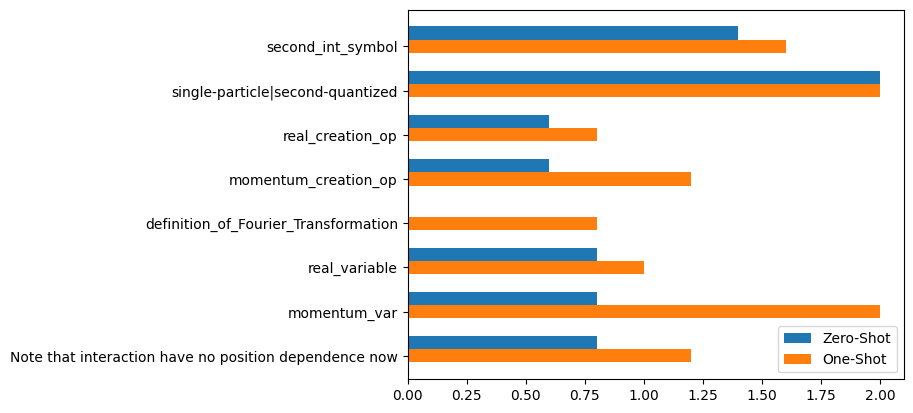

In [19]:
import matplotlib.pyplot as plt

width = 0.3

fig, ax = plt.subplots()
ax.barh(np.arange(8), [e['Zero-Shot'] for e in pl_performance.values()], height=width, label = 'Zero-Shot')
ax.barh(np.arange(8)+width, [e['One-Shot'] for e in pl_performance.values()], height=width, label = 'One-Shot')
ax.set_yticks(np.arange(8)+width, pl_performance.keys())
ax.legend()
ax.invert_yaxis()
plt.show()

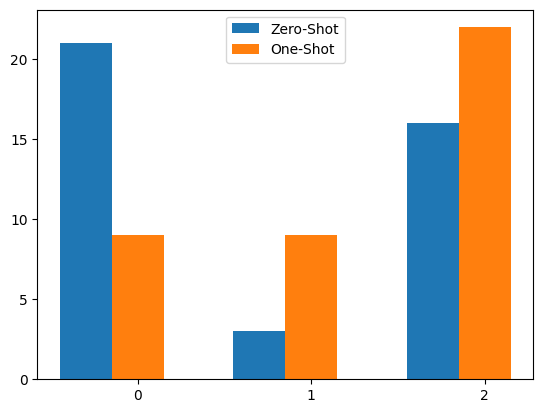

In [20]:
plt.figure()
plt.bar(list(zs_freq.keys()), list(zs_freq.values()), tick_label = list(map(lambda x : str(x), list(zs_freq.keys()))), width = width, label = 'Zero-Shot')
plt.bar(np.array(list(os_freq.keys()))+width, list(os_freq.values()), tick_label = list(map(lambda x : str(x), list(os_freq.keys()))), width = width, label = 'One-Shot')
plt.legend()
plt.show()

In [24]:
print('Zero Shot Aggregate')
print((zs_freq[0]*0 + zs_freq[1]*1 + zs_freq[2]*2)/40)
print('One Shot Aggregate')
print((os_freq[0]*0 + os_freq[1]*1 + os_freq[2]*2)/40)

Zero Shot Aggregate
0.875
One Shot Aggregate
1.325
